### here we use spacy library to train a model to classify emotions based on a given document/tweet
### training data is obtained from ISEAR
### only run the training once since it takes long

In [1]:

#import libraries
import spacy
import random 
nlp    = spacy.load('en_core_web_sm')#load english model
#nlp     = spacy.blank('en')
file    = open("data/train_data.txt","r")#read in training set from text file uses pipe delimiter
f_data  = file.readlines()#read all the lines in the file
file.close()#close the file after reading in the data
train_data=[]#declare the training set array
#read in the training set with the labels
for row in f_data:
    train_data.append( (row.split('|')[0],\
                        {"cats":\
                         {\
                          "anger"    :int(row.split('|')[1]),\
                          "disgust"  :int(row.split('|')[2]),\
                          "fear"     :int(row.split('|')[3]),\
                          "sadness"  :int(row.split('|')[4]),\
                          "shame"    :int(row.split('|')[5]),\
                          "joy"      :int(row.split('|')[6]),\
                          "guilt"    :int(row.split('|')[7])\
                        }}) )
    
#create the spacy nlp pipeline
textcat = nlp.create_pipe('textcat')
#add the pipeline to the nlp model| last=true since we want to add these conponents at the end of the model
nlp.add_pipe(textcat, last=True)
#declare the lables/categories
textcat.add_label('anger')
textcat.add_label('disgust')
textcat.add_label('fear')
textcat.add_label('sadness')
textcat.add_label('shame')
textcat.add_label('joy')
textcat.add_label('guilt')
#give the nlp vectors a name
nlp.vocab.vectors.name ="hassan"
#display the training set and the associated labels
#train_data

In [2]:
#here we begin to train the model
#note this training will take a long time...be patient
#i have also reduced the size of the training set to a very small dataset in order to speed up the taining
#use "train_data_full_set.txt" to get optimul results
optimizer = nlp.begin_training()
#next we will update the model with our own train_data from the csv file
for itn in range(1):
    for doc, gold in train_data:
        random.shuffle(train_data)
        losses = {}
        index = 0
        for text, annotations in train_data:
            nlp.update([doc], [gold], sgd=optimizer, drop=0.45, losses=losses)#drop rate at .45
            print("Iteration: {0}, %{1:.2f} Complete".format((itn+1), index/len(train_data) * 100))#show the progress
            index += 1
        print(losses)
 
#notify training complete
print("Training Complete!")


Iteration: 1, %0.00 Complete
Iteration: 1, %12.50 Complete
Iteration: 1, %25.00 Complete
Iteration: 1, %37.50 Complete
Iteration: 1, %50.00 Complete
Iteration: 1, %62.50 Complete
Iteration: 1, %75.00 Complete
Iteration: 1, %87.50 Complete
{'tagger': 0.004983903147461888, 'textcat': 27.03644323348999}
Iteration: 1, %0.00 Complete
Iteration: 1, %12.50 Complete
Iteration: 1, %25.00 Complete
Iteration: 1, %37.50 Complete
Iteration: 1, %50.00 Complete
Iteration: 1, %62.50 Complete
Iteration: 1, %75.00 Complete
Iteration: 1, %87.50 Complete
{'textcat': 21.601130962371826, 'tagger': 0.004130315686779795}
Iteration: 1, %0.00 Complete
Iteration: 1, %12.50 Complete
Iteration: 1, %25.00 Complete
Iteration: 1, %37.50 Complete
Iteration: 1, %50.00 Complete
Iteration: 1, %62.50 Complete
Iteration: 1, %75.00 Complete
Iteration: 1, %87.50 Complete
{'tagger': 0.008092837233562022, 'textcat': 26.279776215553284}
Iteration: 1, %0.00 Complete
Iteration: 1, %12.50 Complete
Iteration: 1, %25.00 Complete
Ite

### now stream the tweet/document/sentence
### and run it thru the textblob and VaderSentiment

In [3]:
#run this block to stream tweets from twitter

#Import the necessary methods from tweepy library
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import json
import tweepy
import pandas as pd
import matplotlib.pyplot as plt

'''
When using Twitter’s streaming API one must be careful of 
the dangers of rate limiting. If clients exceed a limited 
number of attempts to connect to the streaming API in a window of 
time, they will receive error 420. 
The amount of time a client has to wait after receiving error 
420 will increase exponentially each time they make a failed 
attempt. thus we limit the number of tweets
'''
#this is the list of tweets
tweets = []
num_tweets=5#set the number of tweets i will be working with
search_term="abortion"#search for tweets that mention this word/phrase/"#tag"
#Variables that contains the user credentials to access Twitter API 
access_token        = "3349249780-0DI3pCmJNbGR0p1SGx8qkPOTf5mnbUsthblTzT3"
access_token_secret = "oE6bdfyxwc8vNuYfDHl4NsetW3MlBkZBZ1v8lhFu07QNR"
consumer_key        = "BdidGYYvCI8uIIS72KHkbtOqo"
consumer_secret     = "oemx7gIr6JH7OJeGl2HbAsEtb4ZGv2KqcPi5jBfln517iNAdu2"

#twitter authentication
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
#create api instance
api = tweepy.API(auth)
tweets.clear()#clear the array
#limit the number of tweets and use the search term
for tweet in tweepy.Cursor(api.search, q=search_term, rpp=100, lang="en").items(num_tweets):
    tweets.append(tweet.text)#add the tweets to the array
    print(tweet.text)#print the tweets
   

Eyewitness: Babies born alive after abortion were drowned in saline https://t.co/ykW8gqsZMo
RT @EvanAKilgore: Unpopular opinion time:

-Abortion is not a fundamental human right.

-Abortion has nothing to do with healthcare.

-Abor…
RT @ACLU: BREAKING: Last night, Indiana Governor Holcomb signed a ban on abortion. We've already filed suit.
I really wanna know ppl opinions on abortion 👀👀
RT @ACLU: BREAKING: Last night, Indiana Governor Holcomb signed a ban on abortion. We've already filed suit.


In [4]:
#here we use TextBlob python library to detect sentence/tweet/document polarity as well as subjectivity and store the results
#textblob uses a machine learning approach
from textblob import TextBlob
sentiment_tb_tweets=[]#array will hold the processd tweets with the sentiment and objective labels
index=0
for t in tweets:
    sentiment_tb_tweets.append( TextBlob(t) )#add the processed tweet to the list
    print(sentiment_tb_tweets[index].sentiment)#print the sentiment polarity and subjecivity
    index=index+1
    
sentiment_tb_tweets[0].subjectivity


Sentiment(polarity=0.0, subjectivity=0.25)
Sentiment(polarity=0.14285714285714285, subjectivity=0.31785714285714284)
Sentiment(polarity=0.0, subjectivity=0.06666666666666667)
Sentiment(polarity=0.2, subjectivity=0.2)
Sentiment(polarity=0.0, subjectivity=0.06666666666666667)


0.25

In [5]:
#here we use vadersentiment python library to detect sentence/tweet/document polarity as well as subjectivity and store the results
#vader sentiment is lexicon based
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()#create the vader sentiment analyser object
sentiment_vs_tweets=[]#array will hold the processd tweets with the sentiment and objective labels
index=0
for t in tweets:
    sentiment_vs_tweets.append( analyser.polarity_scores(t) )#add the processed tweet to the list
    print(sentiment_vs_tweets[index])#print the sentiment polarity and subjecivity
    index=index+1

{'neg': 0.252, 'neu': 0.581, 'pos': 0.168, 'compound': -0.3182}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.194, 'neu': 0.806, 'pos': 0.0, 'compound': -0.5574}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.194, 'neu': 0.806, 'pos': 0.0, 'compound': -0.5574}


In [6]:
#determine the class of the tweets using the spacy model trained earlier
#create a document and run it thru the nlp pipeline 
classified_tweets = []#array will hold the spacy classified tweets
index=0
for t in tweets:
    classified_tweets.append(  nlp(t) )
    print( classified_tweets[index].cats )#print the categories/classes of the document
    index=index+1  

{'anger': 0.8638094067573547, 'disgust': 0.41107258200645447, 'fear': 0.007243141997605562, 'sadness': 0.04211084172129631, 'shame': 0.7023115158081055, 'joy': 0.6675902605056763, 'guilt': 0.9010916352272034}
{'anger': 0.7449342012405396, 'disgust': 0.4830150306224823, 'fear': 0.016353892162442207, 'sadness': 0.2870638370513916, 'shame': 0.40636202692985535, 'joy': 0.1324012577533722, 'guilt': 0.41464924812316895}
{'anger': 0.7480689883232117, 'disgust': 0.4755619764328003, 'fear': 0.035106029361486435, 'sadness': 0.1592441201210022, 'shame': 0.4828783869743347, 'joy': 0.16910341382026672, 'guilt': 0.4793942868709564}
{'anger': 0.7859129905700684, 'disgust': 0.47182315587997437, 'fear': 0.026509756222367287, 'sadness': 0.32458046078681946, 'shame': 0.12689484655857086, 'joy': 0.23759214580059052, 'guilt': 0.9908844828605652}
{'anger': 0.7480689883232117, 'disgust': 0.4755619764328003, 'fear': 0.035106029361486435, 'sadness': 0.1592441201210022, 'shame': 0.4828783869743347, 'joy': 0.169

### run the twitter streaming api

In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import threading

import seaborn as sns
import string
import nltk
import warnings 
from wordcloud import WordCloud
import csv
import json
import time

import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sb
from matplotlib import style
import matplotlib.animation as animation
from drawnow import drawnow, figure
from pylab import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

max_array_size            = 200# pop the first element of the array when this limit is reached to prevent mem. overflow
search_terms              = ["trump","abortion","isreal","syria","putin"]#enter the search terms here 
langs                     = ["en"]#the languages ie english
loca_tions                = [ -73.504389,  41.222582, -71.804192 ,42.026518 ]#bounding box of the desired location
tweets                    = []#all the tweets
classified_tweets         = []#array will hold the spacy classified tweets
sentiment_vs_tweets       = []#array will hold the processed tweets with the classified labels
sentiment_tb_tweets       = []#array will hold the processd tweets with the sentiment and objectivity labels
sentiment_polarity_scores = []#pos/neg scores



vs_analyser         = SentimentIntensityAnalyzer()#vaderSentiment analyser

        
#function to remove regex patterns such as user tags in the tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt    

#use stream listner to react whenever a tweet comes in
class StdOutListener(StreamListener):
    def on_data(self, data):
        obj = json.loads(str(data))#convert the tweet into a json format
        #clean the tweets before inserting into the array
        clean_tweet = remove_pattern(obj["text"],"@[\w]*")#remove twitter handles (@user)
        clean_tweet = clean_tweet.replace("[^a-zA-Z#]", " ")#replace puntuation marks
        clean_tweet = clean_tweet.replace("RT :","")#replace the re tweet symbol
        clean_tweet = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', clean_tweet, flags=re.MULTILINE)#remove hyperlinks
        #with open("data/live_twitter_stream.txt","a",encoding="utf-8") as file_live_data:
            #writer = file_live_data.write(str(obj["created_at"])+"|"+clean_tweet+"\n")
            #file_live_data.close()
        #print(clean_tweet)
        score       = vs_analyser.polarity_scores(clean_tweet)
        sentiment_polarity_scores.append( float(score["compound"]) )#append the sentiment score to the array
        sentiment_tb_tweets.append( TextBlob(clean_tweet) )#append the texblob object to the array
        sentiment_vs_tweets.append( nlp(clean_tweet) )#append the vader sentiment object to the array
        tweets.append(clean_tweet)#append the clean tweet to the list of tweets
        #pop the first element to reduce array size and keep the array size in range
        if(len(sentiment_polarity_scores)>=max_array_size):
            sentiment_polarity_scores.pop(0)
            sentiment_tb_tweets.pop(0)
            sentiment_vs_tweets.pop(0)
            tweets.pop(0)
        
        
        time.sleep(1.1)#pause to sync with the spead of the graph in plotting the values
        return(True)

    def on_error(self, status):
        print(status)
        return False

if __name__ == '__main__':
    l      = StdOutListener()
    auth   = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    print("This stream is running!...")
    stream = Stream(auth, l)
    #run this code async 
    streamer=stream.filter(track=search_terms,is_async=True,languages=langs,locations=loca_tions)
    
    


This stream is running!...


<IPython.core.display.Javascript object>


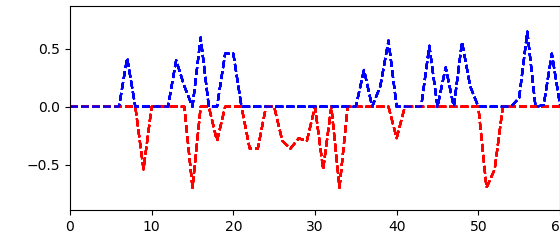

KeyboardInterrupt: 

In [93]:
#plot the sentiment time series in real time
import time
import psutil
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

plt.rcParams['animation.html'] = 'jshtml'

fig1 = plt.figure(figsize=(7,3))
ax1  = fig1.add_subplot(1,1,1)
fig1.show()
i1=0
while True:
    sen_pos = np.array(sentiment_polarity_scores.copy())
    sen_neg = np.array(sentiment_polarity_scores.copy())
    sen_pos[sen_pos>0.0] = 0.0
    sen_neg[sen_neg<0.0] = 0.0
    ax1.plot(sen_pos,"r--")#plot blue for values above zero
    ax1.plot(sen_neg,"b--")#plot red for values below zero
    ax1.set_xlim(left=max(0, i1-50), right=i1+50)#move the graph
    plt.subplots_adjust(left=0.1,bottom=0.3, right=0.8, top=0.98)#adjust the plot axes
    fig1.canvas.draw()
    time.sleep(1.1)#pause
    i1 += 1

<IPython.core.display.Javascript object>


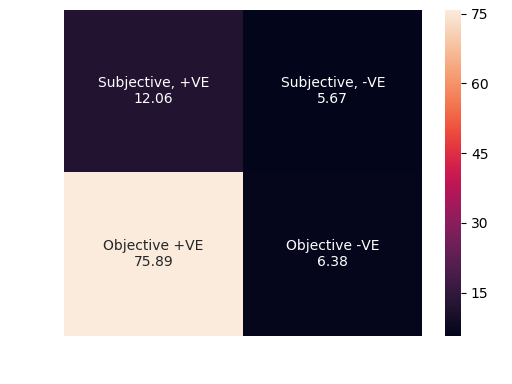

KeyboardInterrupt: 

In [89]:
#heat map in real time
import seaborn as sb
import time
import psutil
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

fig2 = plt.figure()
ax2  = fig2.add_subplot(1,1,1)
fig2.show()

#data will be based on the subjectivity and positivity

while True:
    sub_and_pos=0
    sub_and_neg=0
    obj_and_pos=0
    obj_and_neg=0
    for t in sentiment_tb_tweets:
        so = t.sentiment#subjectivity or objectivity
        if so.subjectivity >= 0.5 and so.polarity>=0:
            sub_and_pos+=1 
        if so.subjectivity >= 0.5 and so.polarity<0:
            sub_and_neg+=1
        if so.subjectivity < 0.5 and so.polarity>=0:
            obj_and_pos+=1
        if so.subjectivity < 0.5 and so.polarity<0:
            obj_and_neg+=1
            
    total       = sub_and_pos + sub_and_neg + obj_and_neg + obj_and_pos
    obj_and_neg_pc = (obj_and_neg/total)*100 #give the percentage
    obj_and_pos_pc = (obj_and_pos/total)*100
    sub_and_neg_pc = (sub_and_neg/total)*100
    sub_and_pos_pc = (sub_and_pos/total)*100
    data        = np.array([[sub_and_pos_pc,sub_and_neg_pc], [obj_and_pos_pc,obj_and_neg_pc]])
    text        = np.asarray([ ["Subjective, +VE"], ["Subjective, -VE"], ["Objective +VE"], ["Objective -VE"] ])
    labels      = (np.asarray(["{0}\n{1:.2f}".format(text,data) for text, data in zip(text.flatten(), data.flatten())])).reshape(2,2)
    plt.clf()#clear the plot
    heat_map    = sb.heatmap(data, xticklabels=False, yticklabels=False,annot=labels, fmt='')
    plt.subplots_adjust(left=0.1,bottom=0.3, right=0.8, top=0.98)#adjust the plot axes
    fig2.canvas.draw()
    time.sleep(1.1)#pause


<IPython.core.display.Javascript object>


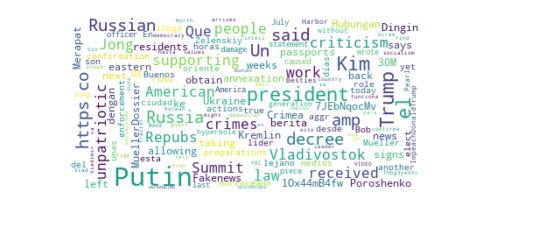

KeyboardInterrupt: 

In [87]:
#word cloud in real time
import numpy as np
import pandas as pd
from os import path
from PIL import Image
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib notebook

fig3 = plt.figure(figsize=(7, 3))
ax3  = fig3.add_subplot(1,1,1)
fig3.show()

while True:
    sent_str = ""
    for i in tweets:
        sent_str += str(i) + " "
        # lower max_font_size, change the maximum number of word and lighten the background:
        wordcloud = WordCloud(max_font_size=30, max_words=999, background_color="white").generate(sent_str)
        ax3.imshow(wordcloud, interpolation="bilinear")
        ax3.axis("off")
        plt.subplots_adjust(left=0.1,bottom=0.3, right=0.6, top=1.0)#adjust the plot axes
        fig3.canvas.draw()
        plt.show()
        time.sleep(1.1)
        ax3.cla()#clear the plot


<IPython.core.display.Javascript object>


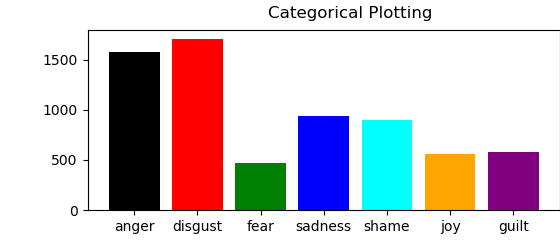

KeyboardInterrupt: 

In [88]:
#histogram with the categories
import matplotlib.pyplot as plt
import time
%matplotlib notebook

fig4 = plt.figure(figsize=(7, 3))
ax4  = fig4.add_subplot(111)
fig4.show()

while True:
    anger   = 0
    disgust = 0
    fear    = 0
    sadness = 0
    shame   = 0
    joy     = 0
    guilt   = 0
    for t in sentiment_vs_tweets:
        anger   += t.cats["anger"]
        disgust += t.cats["disgust"]
        fear    += t.cats["fear"]
        sadness += t.cats["sadness"]
        shame   += t.cats["shame"]
        joy     += t.cats["joy"]
        guilt   += t.cats["guilt"]
        
    data = {'anger': anger, 'disgust': disgust, 'fear': fear, 'sadness': sadness, "shame":shame, "joy":joy, "guilt":guilt}
    names = list(data.keys())
    values = list(data.values())
    ax4.bar(names, values,color=['black', 'red', 'green', 'blue', 'cyan','orange','purple'])
    fig4.suptitle('Categorical Plotting')
    fig4.canvas.draw()
    plt.subplots_adjust(bottom=0.3, right=0.8, top=0.9)#adjust the plot axes
    time.sleep(1.1)#sleep


### run all the graphs simultaneously

<IPython.core.display.Javascript object>


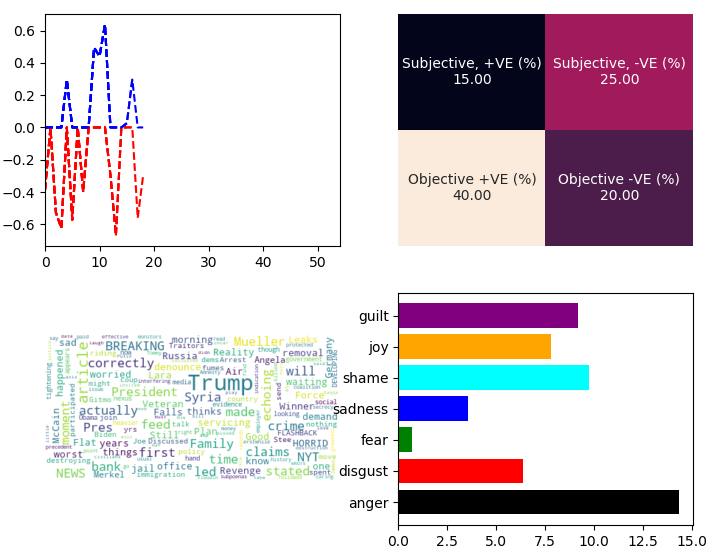

KeyboardInterrupt: 

In [8]:
#plot the sentiment time series in real time
import time
import psutil
import matplotlib.pyplot as plt
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib notebook


plt.rcParams['animation.html'] = 'jshtml'

fig1 = plt.figure(figsize=(9,7))
ax1  = fig1.add_subplot(2,2,1)
ax2  = fig1.add_subplot(2,2,2)
ax3  = fig1.add_subplot(2,2,3)
ax4  = fig1.add_subplot(2,2,4)

fig1.show()
i1=0
while True:
    fig1.canvas.draw()
    ax2.clear()#clear the heatmap before plotting another one
    plt.subplots_adjust(bottom=0.25, top=0.98, right=0.77,left=0.05)#adjust the plot axes
    plt.subplots_adjust(hspace=0.2,wspace=0.2)
    
    '''
    begin time series 
    '''
    sen_pos = np.array(sentiment_polarity_scores.copy())
    sen_neg = np.array(sentiment_polarity_scores.copy())
    sen_pos[sen_pos>0.0] = 0.0
    sen_neg[sen_neg<0.0] = 0.0
    ax1.plot(sen_pos,"r--")#plot blue for values above zero
    ax1.plot(sen_neg,"b--")#plot red for values below zero
    ax1.set_xlim(left=max(0, i1-50), right=i1+50)#move the graph
    time.sleep(1.1)#pause
    i1 += 1
    '''
    end time series
    '''
    #####
    
    '''
    begin heatmap
    '''
    sub_and_pos=0
    sub_and_neg=0
    obj_and_pos=0
    obj_and_neg=0
    for t in sentiment_tb_tweets:
        so = t.sentiment#subjectivity or objectivity
        if so.subjectivity >= 0.5 and so.polarity>=0:
            sub_and_pos+=1 
        if so.subjectivity >= 0.5 and so.polarity<0:
            sub_and_neg+=1
        if so.subjectivity < 0.5 and so.polarity>=0:
            obj_and_pos+=1
        if so.subjectivity < 0.5 and so.polarity<0:
            obj_and_neg+=1
            
    total          = sub_and_pos + sub_and_neg + obj_and_neg + obj_and_pos
    if total==0:
        total=1
    obj_and_neg_pc = (obj_and_neg/total)*100 #give the percentage
    obj_and_pos_pc = (obj_and_pos/total)*100
    sub_and_neg_pc = (sub_and_neg/total)*100
    sub_and_pos_pc = (sub_and_pos/total)*100
    data        = np.array([[sub_and_pos_pc,sub_and_neg_pc], [obj_and_pos_pc,obj_and_neg_pc]])
    text        = np.asarray([ ["Subjective, +VE (%)"], ["Subjective, -VE (%)"], ["Objective +VE (%)"], ["Objective -VE (%)"] ])
    labels      = (np.asarray(["{0}\n{1:.2f}".format(text,data) for text, data in zip(text.flatten(), data.flatten())])).reshape(2,2)
    heat_map    = sb.heatmap(data, xticklabels=False, yticklabels=False,annot=labels, fmt='',ax=ax2,cbar=False)
    '''
    end heatmap
    '''
    
    ####
    
    '''
    begin word cloud
    '''
    sent_str = ""
    for i in tweets:
        sent_str += str(i) + " "
    #lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=30, max_words=999, background_color="white").generate(sent_str)
    ax3.imshow(wordcloud, interpolation="bilinear")
    ax3.axis("off")
    '''
    end word cloud
    '''
    ####
    
    '''
    begin histogram with categories
    '''
    anger   = 0
    disgust = 0
    fear    = 0
    sadness = 0
    shame   = 0
    joy     = 0
    guilt   = 0
    for t in sentiment_vs_tweets:
        anger   += t.cats["anger"]
        disgust += t.cats["disgust"]
        fear    += t.cats["fear"]
        sadness += t.cats["sadness"]
        shame   += t.cats["shame"]
        joy     += t.cats["joy"]
        guilt   += t.cats["guilt"]
        
    data = {'anger': anger, 'disgust': disgust, 'fear': fear, 'sadness': sadness, "shame":shame, "joy":joy, "guilt":guilt}
    names = list(data.keys())
    values = list(data.values())
    ax4.barh(names, values,color=['black', 'red', 'green', 'blue', 'cyan','orange','purple'])
    '''
    end histogram with categories
    '''
    